### Imports

#### python imports

In [1]:
import os
import cv2
import yaml
import torch
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt

from albumentations import random_utils
from scipy.optimize import curve_fit
from torch.utils.data import DataLoader

#### nem imports

In [2]:
os.sys.path.append('/workspace/nem/NEM/train')

In [3]:
from train.data import *
from train.utils import *
from train.model import NeuralNetwork
from train.train import train

### Features extraction

shape : (980, 1468, 3)
vertical : ['real_estate']
exposure : [0.5884]



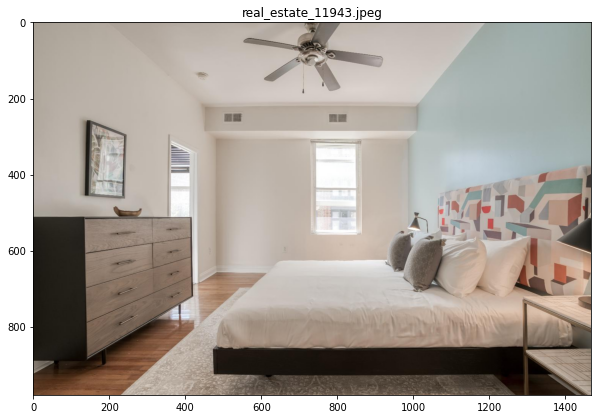

In [4]:
# select a random image
folder_path = "/workspace/datasets/noise_dataset/images/"
csv_path = "/workspace/datasets/noise_dataset/noise_dataset.csv"
image_folder = os.listdir(folder_path)

i = random.randint(0, len(image_folder))

image_name = image_folder[i]
image_path = os.path.join(folder_path, image_name)

df = pd.read_csv(csv_path, index_col=0)

vertical = df[df["image_name"] == image_name]['vertical'].values
exposure = df[df["image_name"] == image_name]['exposure'].values

image = plt.imread(image_path)
print(f"shape : {image.shape}")
print(f"vertical : {vertical}")
print(f"exposure : {exposure}\n")
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.title(image_name)
plt.show()

#### kurtosis 

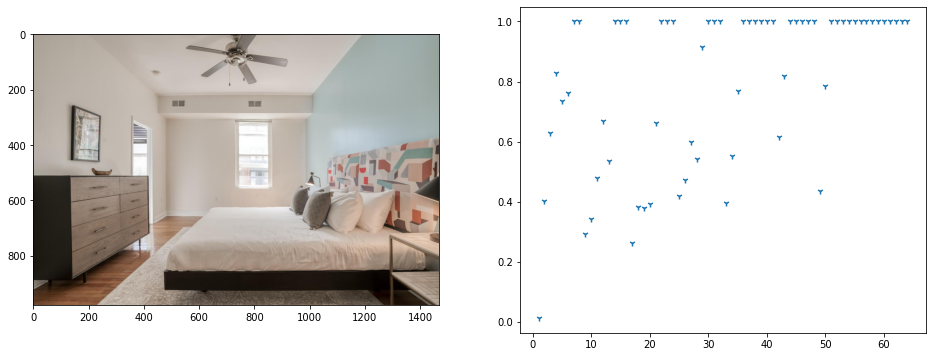

In [5]:
kurtosis = compute_kurtosis(discrete_cosine_transform(image))

fig, axs = plt.subplots(1, 2, figsize=(16,6))

axs[0].imshow(image)
axs[1].scatter(x=np.arange(1,65), y=kurtosis, marker='1')

plt.show()

In [6]:
exposure = np.array([3.564]).reshape((1,1))

#exposure.shape

features = np.concatenate((exposure, kurtosis), axis=1)

torch.tensor(features)

tensor([[3.5640, 0.0127, 0.4020, 0.6292, 0.8268, 0.7352, 0.7619, 1.0000, 1.0000,
         0.2917, 0.3428, 0.4793, 0.6678, 0.5348, 1.0000, 1.0000, 1.0000, 0.2630,
         0.3817, 0.3776, 0.3930, 0.6633, 1.0000, 1.0000, 1.0000, 0.4194, 0.4728,
         0.5985, 0.5414, 0.9137, 1.0000, 1.0000, 1.0000, 0.3946, 0.5534, 0.7694,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6139, 0.8181, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.4357, 0.7843, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]], dtype=torch.float64)

#### brisque features

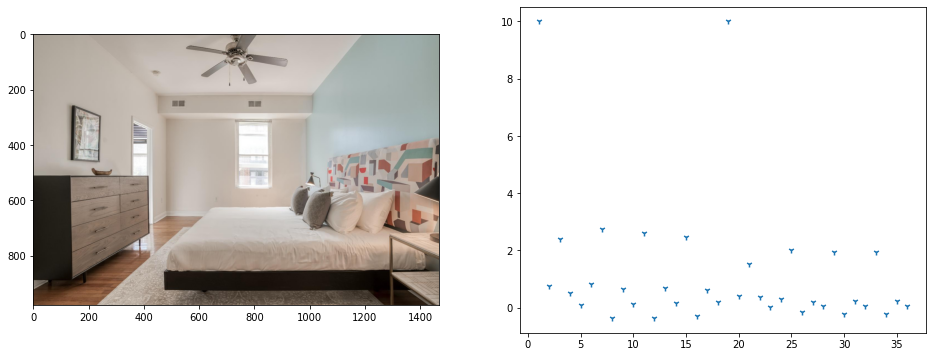

In [7]:
brisque_ftrs = brisque(image)

fig, axs = plt.subplots(1, 2, figsize=(16,6))

axs[0].imshow(image)
axs[1].scatter(x=np.arange(1,37), y=brisque_ftrs, marker='1')

plt.show()

### Degradation pipeline

#### noise creation

##### iso noise

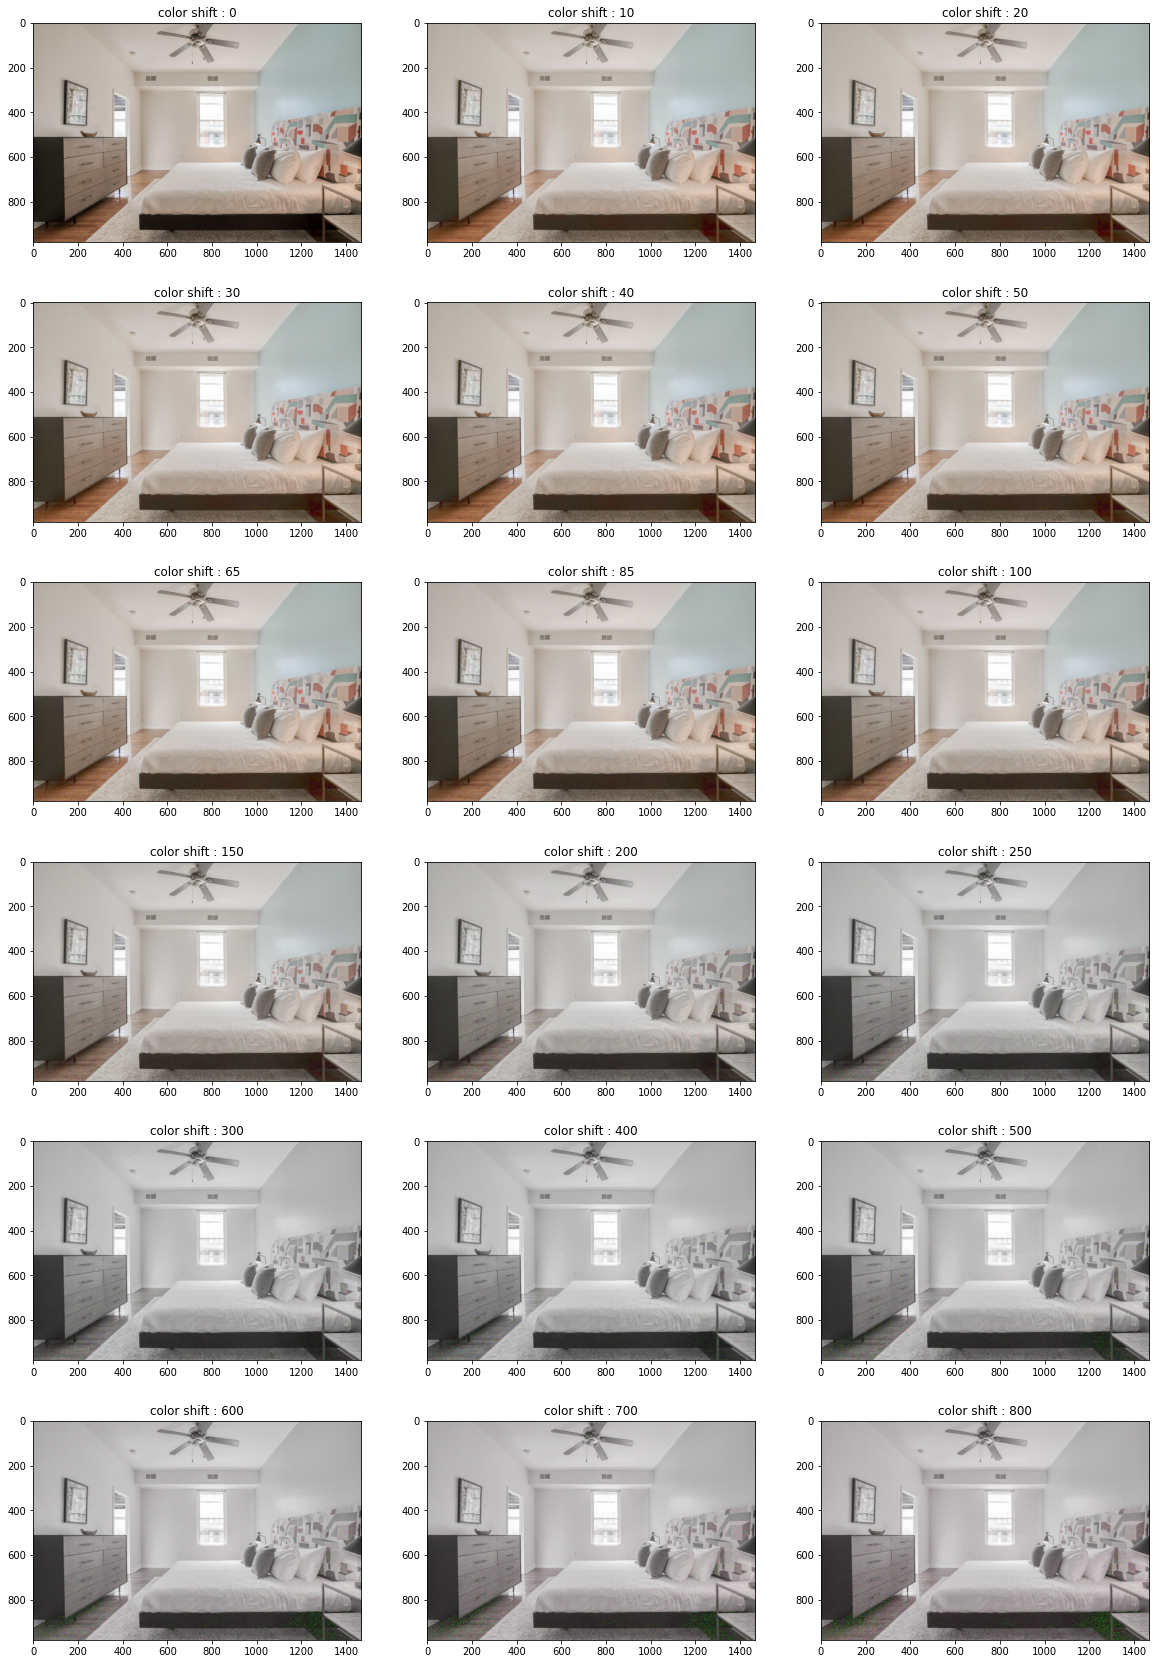

In [8]:
cs_range = [0, 10, 20, 30, 40, 50, 65, 85, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800]

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(20, 30))

for idx, cs in enumerate(cs_range): 

    image_iso, _, _ = iso_noise(image, color_shift=0.0027*cs)
    r = idx // 3
    c = idx % 3
    axs[r][c].imshow(image_iso)
    axs[r][c].set_title(f"color shift : {cs}")
    
plt.show()

##### gaussian noise

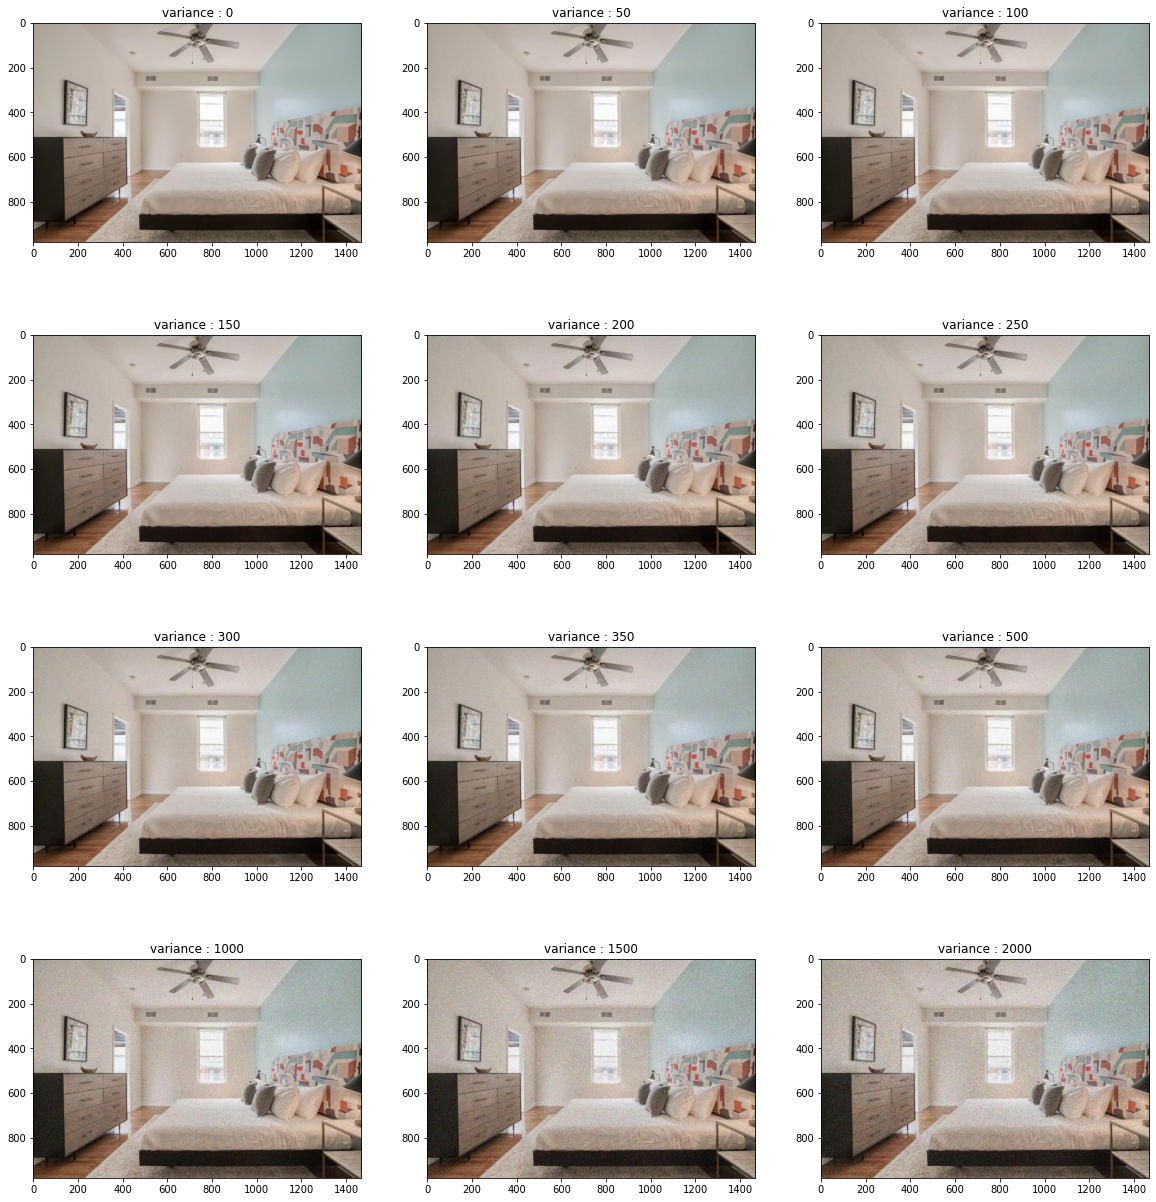

In [9]:
v_range = [0, 50, 100, 150, 200, 250, 300, 350, 500, 1000, 1500, 2000]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 22))

for idx, v in enumerate(v_range): 

    transform = A.augmentations.transforms.GaussNoise(var_limit = (v,v), mean = 0, per_channel = True, p=1)
    image_gaussian = transform(image=image)
    
    r = idx // 3
    c = idx % 3
    axs[r][c].imshow(image_gaussian['image'])
    axs[r][c].set_title(f"variance : {v}")
    
plt.show()

#### noise scoring

In [10]:
def sigmoid(x, x0, k, b):
    y = b - b/(1 + np.exp(-k*(x-x0)))
    return y

##### iso noise degradation - score mapping

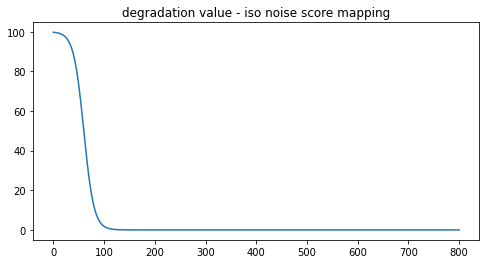

In [11]:
popt_iso = [60, 0.1, 100]
x = np.linspace(0, 800, 1000)
y = [sigmoid(i, popt_iso[0], popt_iso[1], popt_iso[2]) for i in x]

fig = plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.title("degradation value - iso noise score mapping")
plt.show()

##### gaussian noise degradation - score mapping

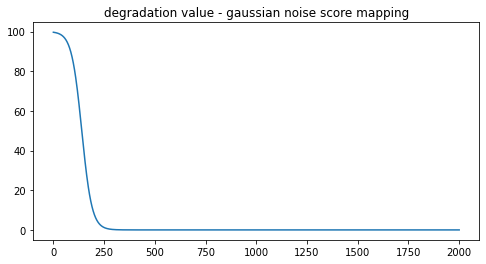

In [12]:
popt_gaussian = [140, 0.04, 100]
x = np.linspace(0, 2000, 1000)
y = [sigmoid(i, popt_gaussian[0], popt_gaussian[1], popt_gaussian[2]) for i in x]

fig = plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.title("degradation value - gaussian noise score mapping")
plt.show()

### Degraded images with features

#### iso noise

##### kurtosis

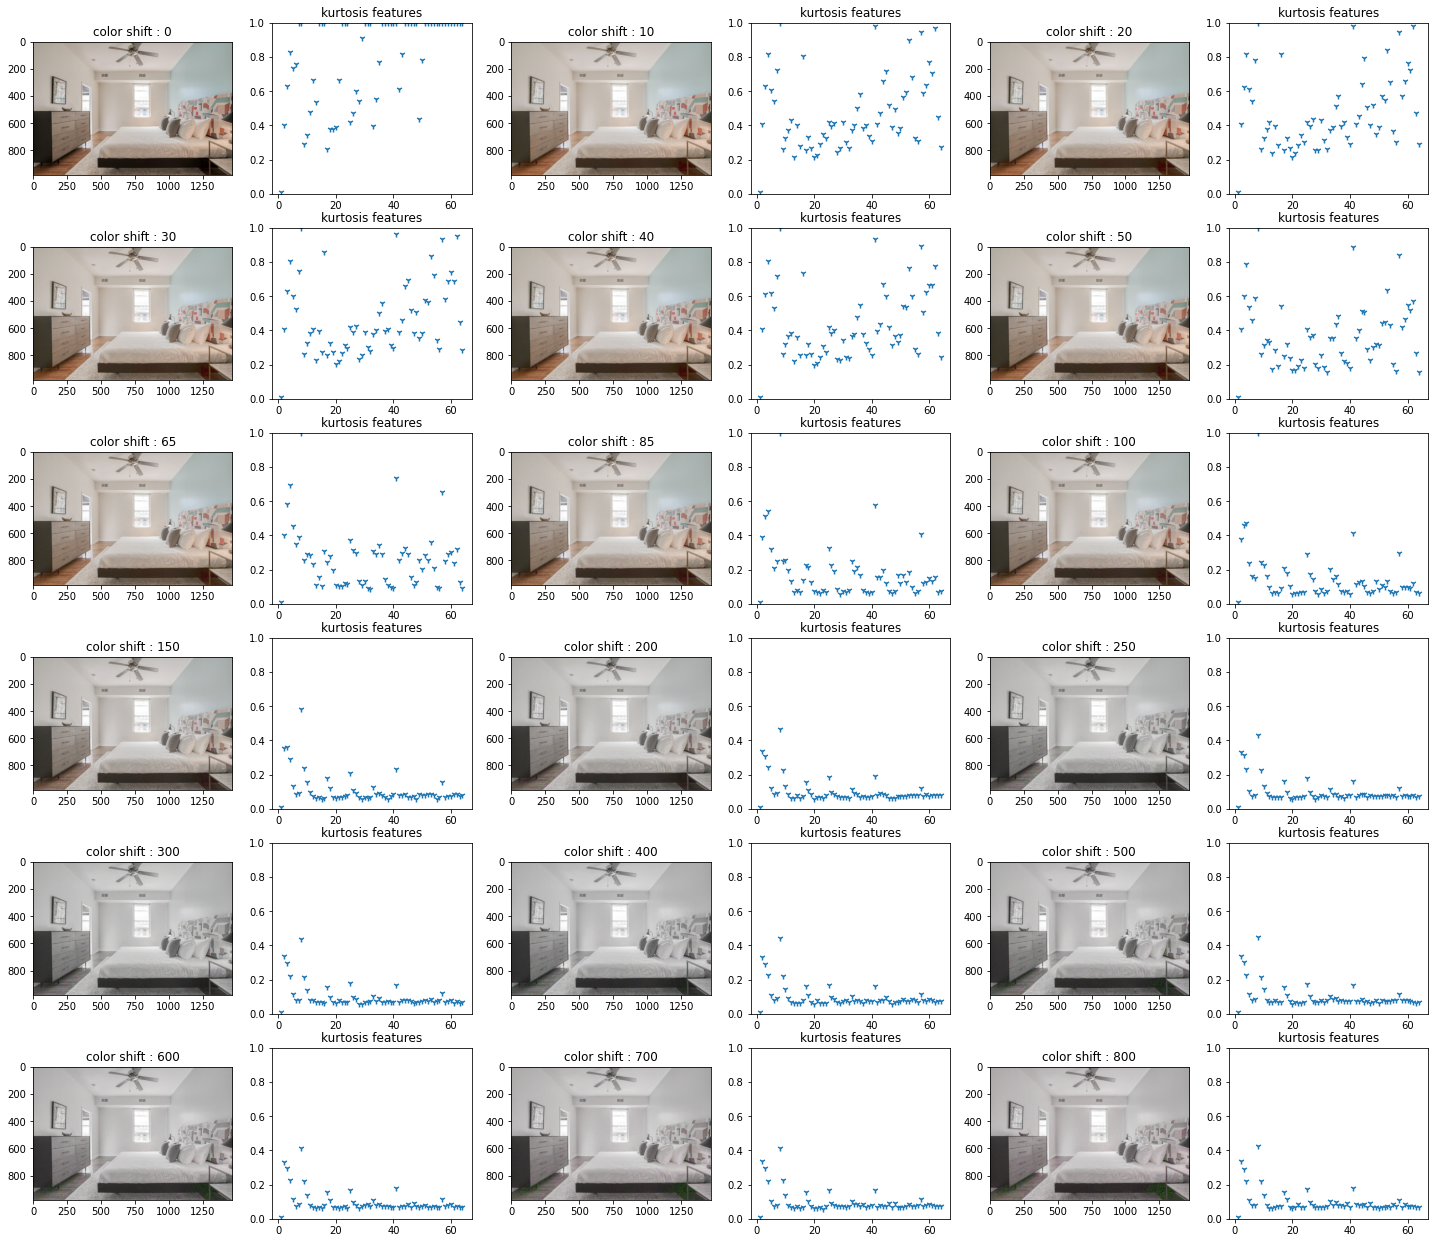

In [13]:
cs_range = [0, 10, 20, 30, 40, 50, 65, 85, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800]
x_kurtosis = np.arange(1, 65, 1)

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(25, 22))

for idx, cs in enumerate(cs_range): 

    image_iso, _, _ = iso_noise(image, color_shift=0.0027*cs)
    features = compute_kurtosis(discrete_cosine_transform(image_iso))
    r = idx // 3
    c = (idx % 3)*2
    axs[r][c].imshow(image_iso)
    axs[r][c].set_title(f"color shift : {cs}")
    axs[r][c+1].scatter(x=x_kurtosis, y=features, marker='1')
    axs[r][c+1].set_title("kurtosis features")
    axs[r][c+1].set_ylim(0,1)
    
plt.show()

##### brisque

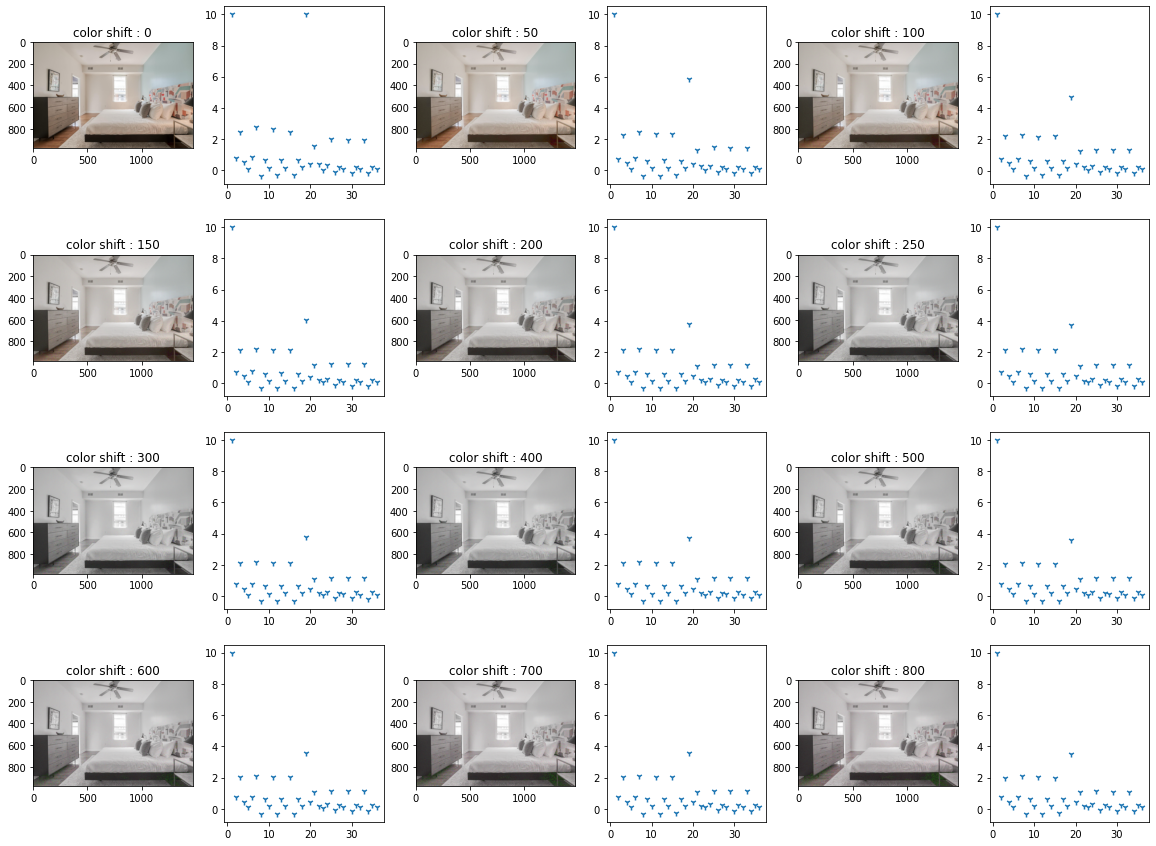

In [14]:
cs_range = [0, 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800]
x_brisque = np.arange(1, 37, 1)

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(20, 15))

for idx, cs in enumerate(cs_range): 

    image_iso, _, _ = iso_noise(image, color_shift=0.0027*cs)
    features = brisque(image_iso)
    r = idx // 3
    c = (idx % 3)*2
    axs[r][c].imshow(image_iso)
    axs[r][c].set_title(f"color shift : {cs}")
    axs[r][c+1].scatter(x=x_brisque, y=features, marker='1')
    
plt.show()

#### gaussian noise

##### kurtosis

IndexError: index 5 is out of bounds for axis 0 with size 5

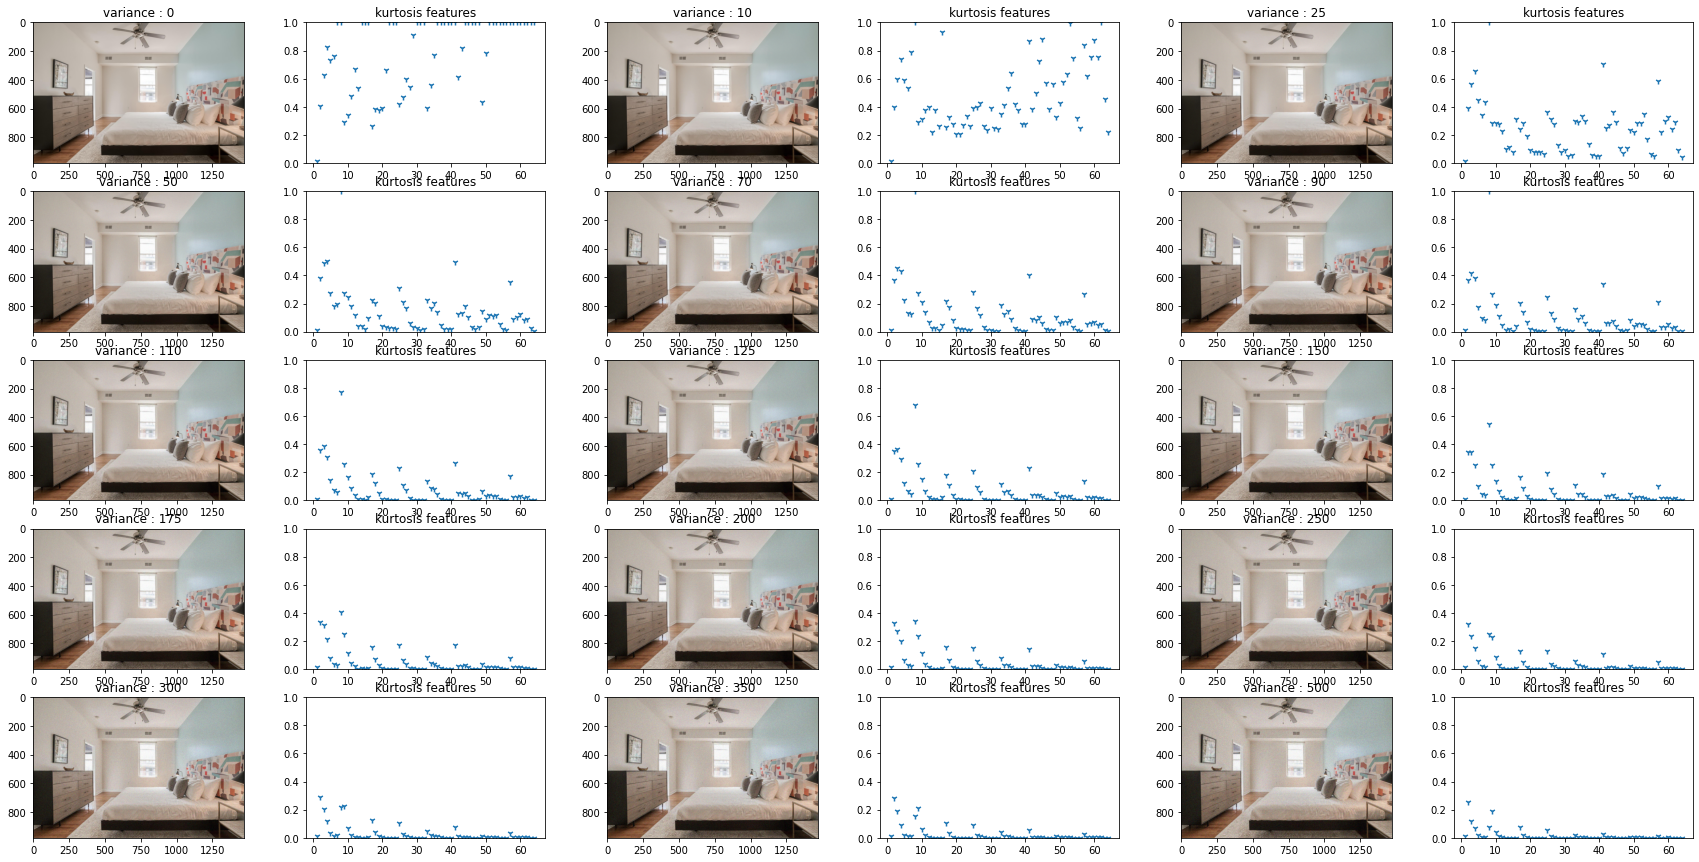

In [15]:
v_range = [0, 10, 25, 50, 70, 90, 110, 125, 150, 175, 200, 250, 300, 350, 500, 100, 1500, 2000]
x_kurtosis = np.arange(1, 65, 1)

fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(30, 15))

for idx, v in enumerate(v_range): 

    transform = A.augmentations.transforms.GaussNoise(var_limit = (v,v), mean = 0, per_channel = True, p=1)
    image_gaussian = transform(image=image)
    features = compute_kurtosis(discrete_cosine_transform(image_gaussian['image']))
    
    
    r = idx // 3
    c = (idx % 3)*2
    axs[r][c].imshow(image_gaussian['image'])
    axs[r][c].set_title(f"variance : {v}")
    axs[r][c+1].scatter(x=x_kurtosis, y=features, marker='1')
    axs[r][c+1].set_title("kurtosis features")
    axs[r][c+1].set_ylim(0,1)
    
plt.show()

##### brisque

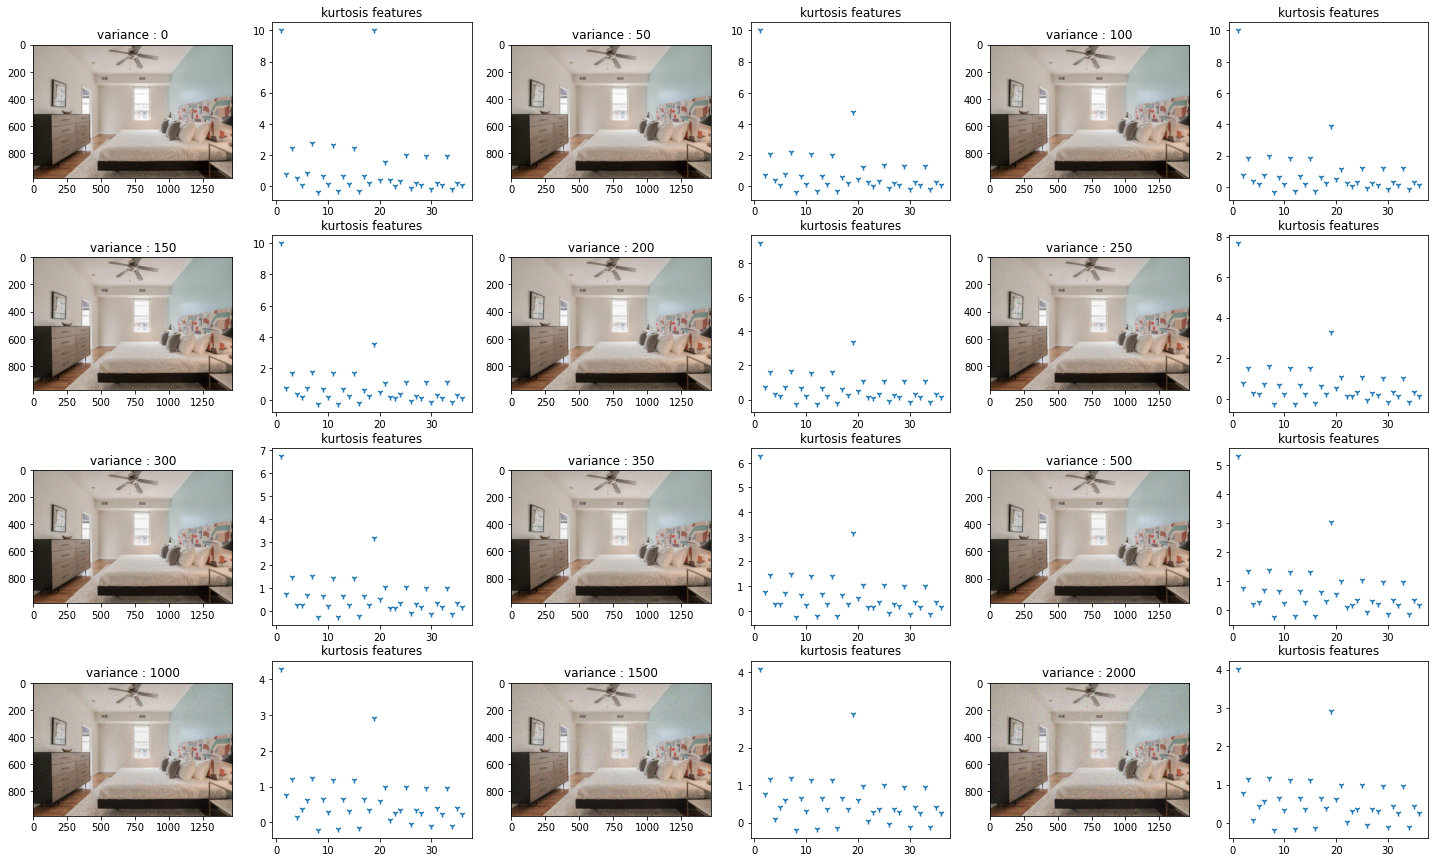

In [16]:
v_range = [0, 50, 100, 150, 200, 250, 300, 350, 500, 1000, 1500, 2000]
x_brisque = np.arange(1, 37, 1)

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(25, 15))

for idx, v in enumerate(v_range): 

    transform = A.augmentations.transforms.GaussNoise(var_limit = (v,v), mean = 0, per_channel = True, p=1)
    image_gaussian = transform(image=image)

    features = brisque(image_gaussian['image'])
    r = idx // 3
    c = (idx % 3)*2
    axs[r][c].imshow(image_gaussian['image'])
    axs[r][c].set_title(f"variance : {v}")
    axs[r][c+1].set_title("brisque features")
    axs[r][c+1].scatter(x=x_brisque, y=features, marker='1')
    
plt.show()